In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
from sklearn.preprocessing import StandardScaler
import scipy.stats as st

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# tested lib
from ab_test.user import User
from ab_test.experiment import *
from ab_test.hasher_implems import *

from tools.chi_squared import ChiSquaredTest as chi
from tools.data import DataHelper

import time

# Chi Squared Test

We consider experiments with 2 variations of 50% each.

## Definitions

### Hypothesis

* Experiment A has _r = 2_ levels (variation 1 and variation 2)
* Experiment B has _c = 2_ levels (variation 1 and variation 2)

The null hypothesis states that knowing the variation in experiment A does not help you predict the variation in experiment B.

Ho: Variable A and Variable B are independent.

Ha: Variable A and Variable B are not independent.

### Degrees of Freedom

`DF = (r - 1) * (c - 1) = 1`

### Expected Frequencies

The expected frequency counts are computed separately for each level of one categorical variable at each level of the other categorical variable. Compute r * c expected frequencies, according to the following formula.
`Er,c = (nr * nc) / n`

where Er,c is the expected frequency count for level r of Variable A and level c of Variable B, nr is the total number of sample observations at level r of Variable A, nc is the total number of sample observations at level c of Variable B, and n is the total sample size.

For example, for a sample of 100 users, in a perfect case, we would have:

`Er,c = (50*50) / 100 = 25`

### Test Statistic

The test statistic is a chi-square random variable (Χ2) defined by the following equation.
`Χ2 = Σ [ (Or,c - Er,c)2 / Er,c ]`

where Or,c is the observed frequency count at level r of Variable A and level c of Variable B, and Er,c is the expected frequency count at level r of Variable A and level c of Variable B.


### P-value

The P-value is the probability of observing a sample statistic as extreme as the test statistic.

### Conclude

* If observed chi-square < critical chi-square, then variables are not related.
* If observed chi-square > critical chi-square, then variables are not independent (and hence may be related).

For DF=1 and a precision of 5% (α=0.05), the critical chi-square is 3.841.

## Tools

### Test definitions

In [2]:
population = 1000
nb_exp = 1000

In [3]:
!pip install joblib

In [4]:
from joblib import Parallel, delayed
def chi_evaluation_over_populations(nb_experiments, log_scale_populations, hashers, nb_jobs):
    chi_squre = {hasher_name: list() for hasher_name, hasher in hashers.items()}
    for hasher_name, hasher in hashers.items():
        for log_population in log_scale_populations:
            print('Computing chi square for {hasher_name} hash function on 10^{log_population} users'.format(
                hasher_name=hasher_name,
                log_population=log_population))
            chi_values = Parallel(n_jobs=nb_jobs)(delayed(compute_chi_square)(hasher, 10**log_population) 
                                                   for _ in range(nb_experiments))
            # print(chi_values)
            chi_squre[hasher_name].append(sorted(chi_values)[nb_experiments // 2])
    return chi_squre

In [5]:
def compute_chi_square(hasher, population):
    return chi.statistic_test(DataHelper.generate(hasher, population))

In [6]:
nb_experiments = 20
log_scale_populations = [1, 2, 3, 4, 5, 6]

hashers = {
    "built-in": BuiltInHasher(),
    "md5": Md5Hasher(),
    "sha256": Sha256Hasher()
}
nb_jobs = 8

In [8]:
chi_square = chi_evaluation_over_populations(nb_experiments, log_scale_populations, hashers, nb_jobs)

Computing chi square for built-in hash function on 10^1 users
Computing chi square for built-in hash function on 10^2 users
Computing chi square for built-in hash function on 10^3 users
Computing chi square for built-in hash function on 10^4 users
Computing chi square for built-in hash function on 10^5 users
Computing chi square for built-in hash function on 10^6 users
Computing chi square for md5 hash function on 10^1 users
Computing chi square for md5 hash function on 10^2 users
Computing chi square for md5 hash function on 10^3 users
Computing chi square for md5 hash function on 10^4 users
Computing chi square for md5 hash function on 10^5 users
Computing chi square for md5 hash function on 10^6 users
Computing chi square for sha256 hash function on 10^1 users
Computing chi square for sha256 hash function on 10^2 users
Computing chi square for sha256 hash function on 10^3 users
Computing chi square for sha256 hash function on 10^4 users
Computing chi square for sha256 hash function 

In [9]:
chi_square

{'built-in': [1.2698412698412698,
  0.37205456800330716,
  0.45825227596578405,
  0.6001977739844178,
  0.5953873988074859,
  0.4696830682708968],
 'md5': [0.6250000000000001,
  0.8914469848740211,
  0.7629888771722095,
  0.6019726115362953,
  0.5103958153466837,
  1.3424124898467955],
 'sha256': [0.47619047619047616,
  0.594574507617987,
  1.01657371215682,
  0.5999059441499718,
  0.6727491297912361,
  0.7639091050874401]}

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

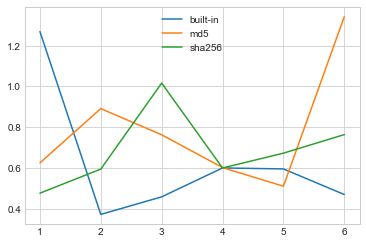

In [11]:
fig = plt.figure()
ax = plt.axes()
for hasher_name, chi_values in chi_square.items():
    ax.plot(log_scale_populations, chi_values, label=hasher_name)

plt.legend();